<a href="https://colab.research.google.com/github/suryatejabatchu08/Machine-Learning-Lab/blob/main/Lab3_AP23110010549.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎯 Feature Engineering — Part A: Individual Concepts (Colab-Ready)

**Updated:** 2025-08-22

This notebook is designed for **first-time learners**. You will practice each feature engineering step **individually** (no pipelines yet), so you can clearly see *what each step does* and *why it matters*.

**What you'll practice:**
- Dataset loading & quick audit
- Handling missing values (drop, impute)
- Scaling & normalization (standardization, min-max, per-row normalization)
- Encoding categorical variables (ordinal vs one-hot)
- Feature transformations (log, power, polynomial)
- Simple dimensionality reduction (PCA) for visualization
- Short exercises after each section

> Use this Part A first. After you are comfortable, move to **Part B (Pipelines)** to automate and combine steps.

## 0) Setup

In [1]:
# If running in Google Colab, you can install optional packages here:
# !pip install -q statsmodels==0.14.2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, OrdinalEncoder
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

pd.set_option('display.max_columns', 100)

## 1) Dataset Setup & Quick Audit

In [2]:
# Option A: Load Titanic from a stable GitHub mirror (recommended for first run)
URL = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
df = pd.read_csv(URL)
print("Shape:", df.shape)
df.head()

Shape: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Option B: Upload your own CSV (uncomment to use in Colab)
# from google.colab import files
# up = files.upload()  # pick file
# import io
# df = pd.read_csv(io.BytesIO(up[list(up.keys())[0]]))
# print("Shape:", df.shape)
# df.head()

In [4]:
# Quick audit
print("\nInfo:")
df.info()
print("\nMissing values per column:")
print(df.isna().sum().sort_values(ascending=False))
print("\nNumeric describe:")
df.describe().T


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

Missing values per column:
Cabin          687
Age            177
Embarked         2
PassengerId      0
Name             0
Pclass           0
Survived         0
Sex              0
Parch            0
SibSp            0
Fare             0


,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


## 2) Handling Missing Values (Individually)

**Goal:** Learn when to **drop** vs **impute**.

**Common choices**
- Numeric: mean/median
- Categorical: most frequent

We'll practice on Titanic columns like `Age`, `Embarked`, and `Cabin`.

In [5]:
# View null counts
df.isna().sum().sort_values(ascending=False).head(10)

,0
Cabin,687
Age,177
Embarked,2
PassengerId,0
Name,0
Pclass,0
Survived,0
Sex,0
Parch,0
SibSp,0


In [6]:
# 2.1 DROP example (use cautiously)
df_drop_rows = df.dropna(subset=['Age', 'Embarked'])  # drop rows where these are null
print("Original:", df.shape, "After drop:", df_drop_rows.shape)

Original: (891, 12) After drop: (712, 12)


In [7]:
# 2.2 SIMPLE IMPUTE example
df_imp = df.copy()
# Numeric (Age): median
df_imp['Age'] = df_imp['Age'].fillna(df_imp['Age'].median())
# Categorical (Embarked): most frequent
df_imp['Embarked'] = df_imp['Embarked'].fillna(df_imp['Embarked'].mode()[0])

# 'Cabin' is very sparse; we can fill with "Unknown"
df_imp['Cabin'] = df_imp['Cabin'].fillna('Unknown')

df_imp.isna().sum().head(10)

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,0


In [8]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
# 2.3 KNN Imputation (numeric only demonstration)
num_cols = df.select_dtypes(include=['number']).columns.tolist()
print(num_cols)
knn_df = df[num_cols].copy()
print("knn_df: ", knn_df.isna().sum())
#print(knn_df)
imputer = KNNImputer(n_neighbors=3)
knn_imputed = imputer.fit_transform(knn_df)
print(knn_imputed[0])
knn_imputed_df = pd.DataFrame(knn_imputed, columns=num_cols)
knn_imputed_df.head()
knn_imputed_df.isna().sum()

['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
knn_df:  PassengerId      0
Survived         0
Pclass           0
Age            177
SibSp            0
Parch            0
Fare             0
dtype: int64
[ 1.    0.    3.   22.    1.    0.    7.25]


,0
PassengerId,0
Survived,0
Pclass,0
Age,0
SibSp,0
Parch,0
Fare,0


**📝 Exercise 2**
1) Compare **mean vs median** imputation for `Age`. Which preserves the original distribution better?  
2) For `Embarked`, try filling with a new category (`'Unknown'`) vs mode. What changes in `value_counts()`?

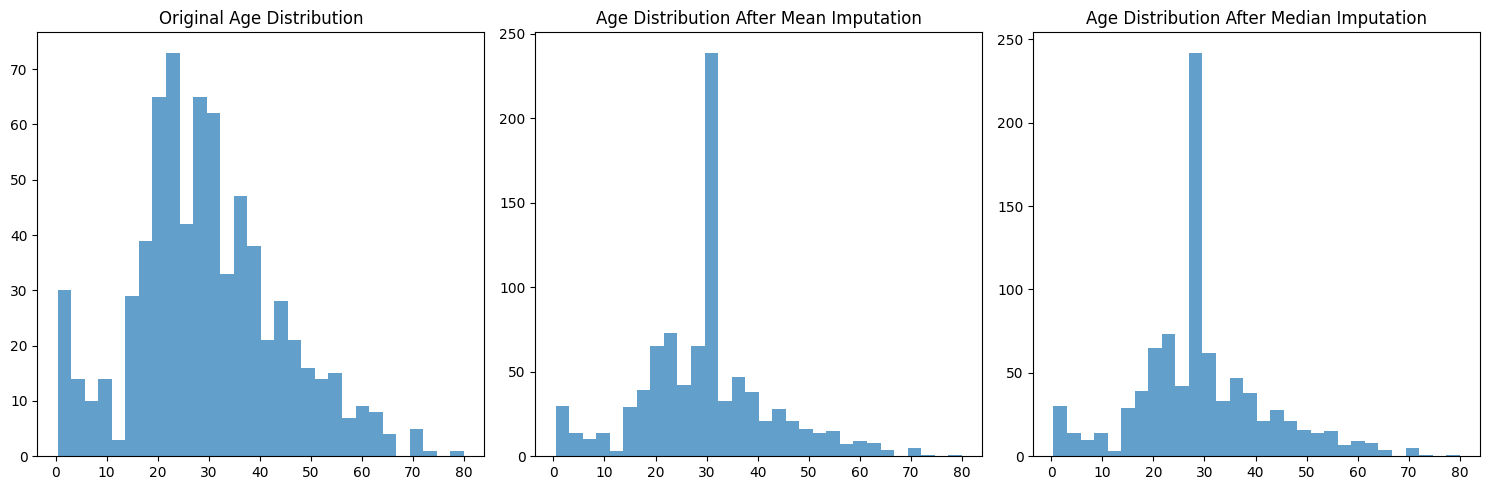


Embarked Value Counts (Original):
Embarked
S      644
C      168
Q       77
NaN      2
Name: count, dtype: int64

Embarked Value Counts (Filled with 'Unknown'):
Embarked
S          644
C          168
Q           77
Unknown      2
Name: count, dtype: int64

Embarked Value Counts (Filled with Mode):
Embarked
S    646
C    168
Q     77
Name: count, dtype: int64


In [10]:
# Exercise 2, 1) Compare mean vs median imputation for Age
df_age_mean = df.copy()
df_age_median = df.copy()

# Impute with mean
mean_age = df_age_mean['Age'].mean()
df_age_mean['Age'] = df_age_mean['Age'].fillna(mean_age)

# Impute with median
median_age = df_age_median['Age'].median()
df_age_median['Age'] = df_age_median['Age'].fillna(median_age)

# Plot histograms to compare distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].hist(df['Age'].dropna(), bins=30, alpha=0.7)
axes[0].set_title('Original Age Distribution')

axes[1].hist(df_age_mean['Age'], bins=30, alpha=0.7)
axes[1].set_title('Age Distribution After Mean Imputation')

axes[2].hist(df_age_median['Age'], bins=30, alpha=0.7)
axes[2].set_title('Age Distribution After Median Imputation')

plt.tight_layout()
plt.show()

# Exercise 2, 2) Compare filling Embarked with 'Unknown' vs mode
df_embarked_unknown = df.copy()
df_embarked_mode = df.copy()

# Fill with 'Unknown'
df_embarked_unknown['Embarked'] = df_embarked_unknown['Embarked'].fillna('Unknown')

# Fill with mode
mode_embarked = df_embarked_mode['Embarked'].mode()[0]
df_embarked_mode['Embarked'] = df_embarked_mode['Embarked'].fillna(mode_embarked)

# Compare value counts
print("\nEmbarked Value Counts (Original):")
print(df['Embarked'].value_counts(dropna=False))

print("\nEmbarked Value Counts (Filled with 'Unknown'):")
print(df_embarked_unknown['Embarked'].value_counts(dropna=False))

print("\nEmbarked Value Counts (Filled with Mode):")
print(df_embarked_mode['Embarked'].value_counts(dropna=False))

## 3) Scaling & Normalization (Individually)

- **Standardization**: z = (x - mean)/std (good for many ML models)
- **MinMax scaling**: maps to [0,1] (useful when features have different units)
- **Per-row Normalization**: scales each *row vector* to unit norm (useful for text-like frequency vectors)

We'll demonstrate on `Fare` and `Age`.

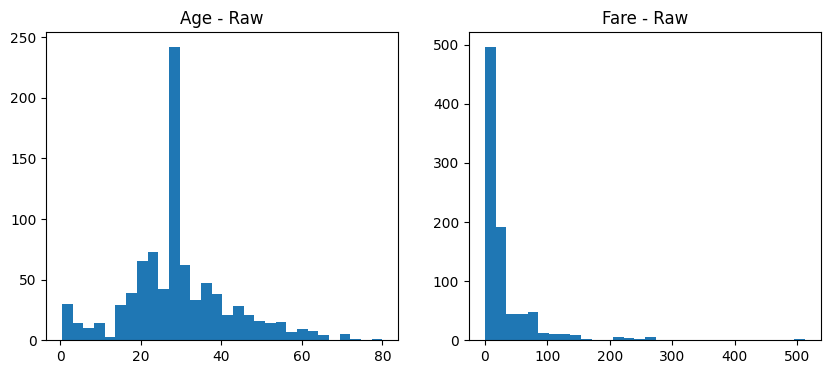

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(df_imp['Age'].dropna(), bins=30)
axes[0].set_title('Age - Raw')
axes[1].hist(df_imp['Fare'].dropna(), bins=30)
axes[1].set_title('Fare - Raw')
plt.show()

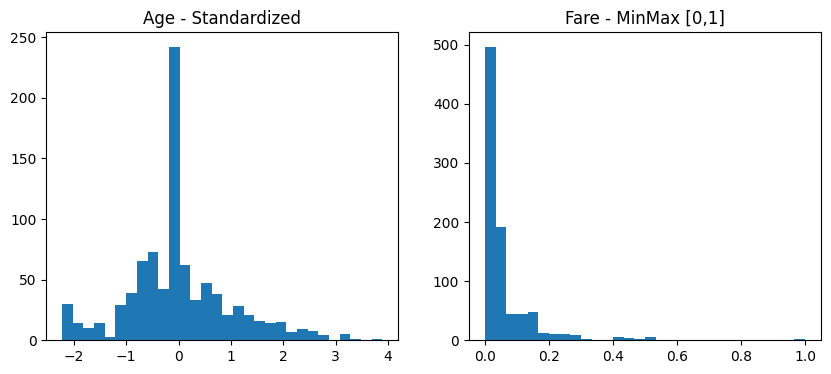

In [12]:
sc_std = StandardScaler()
sc_mm  = MinMaxScaler()

age_std = sc_std.fit_transform(df_imp[['Age']])
fare_mm = sc_mm.fit_transform(df_imp[['Fare']])

fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(age_std.flatten(), bins=30)
axes[0].set_title('Age - Standardized')
axes[1].hist(fare_mm.flatten(), bins=30)
axes[1].set_title('Fare - MinMax [0,1]')
plt.show()

**📝 Exercise 3**
1) Standardize `Fare` and plot the histogram.  
2) Apply **Normalizer** on `[Age, Fare]` rows and check the first 5 normalized vectors.

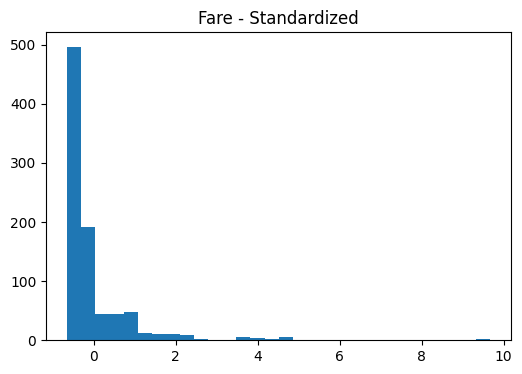


First 5 normalized [Age, Fare] vectors:
[[0.94975704 0.31298812]
 [0.47041706 0.88244422]
 [0.95655127 0.29156418]
 [0.55033828 0.83494178]
 [0.97455519 0.22414769]]


In [20]:
# Exercise 3, 1) Standardize Fare and plot the histogram
sc_std_fare = StandardScaler()
fare_std = sc_std_fare.fit_transform(df_imp[['Fare']])

plt.figure(figsize=(6, 4))
plt.hist(fare_std.flatten(), bins=30)
plt.title('Fare - Standardized')
plt.show()

# Exercise 3, 2) Apply Normalizer on [Age, Fare] rows and check the first 5 normalized vectors
normalizer = Normalizer()
age_fare_normalized = normalizer.fit_transform(df_imp[['Age', 'Fare']])

print("\nFirst 5 normalized [Age, Fare] vectors:")
print(age_fare_normalized[:5])

## 4) Encoding Categorical Variables (Individually)

- **Ordinal/Label encoding**: map categories to integers (assumes order or used with tree models).  
- **One-Hot encoding**: binary column per category (no order assumption).

We'll use `Sex` and `Embarked` as examples.

In [25]:
# 4.1 Ordinal encoding demo (note: no real order in Sex/Embarked; this is just to illustrate)
enc = OrdinalEncoder()
ord_demo = df_imp[['Sex','Embarked']].copy()
ord_vals = enc.fit_transform(ord_demo)
pd.DataFrame(ord_vals, columns=['Sex_ord','Embarked_ord']).head()

,Sex_ord,Embarked_ord
0,1.0,2.0
1,0.0,0.0
2,0.0,2.0
3,0.0,2.0
4,1.0,2.0


In [28]:
# 4.2 One-Hot encoding demo with pandas
ohe_embarked = pd.get_dummies(df_imp['Embarked'], prefix='Embarked')
ohe_sex = pd.get_dummies(df_imp['Sex'], prefix='Sex')
encoded_df = pd.concat([df_imp[['Survived','Age','Fare']], ohe_sex, ohe_embarked], axis=1)
encoded_df.head()

,Survived,Age,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,22.0,7.2500,False,True,False,False,True
1,1,38.0,71.2833,True,False,True,False,False
2,1,26.0,7.9250,True,False,False,False,True
3,1,35.0,53.1000,True,False,False,False,True
4,0,35.0,8.0500,False,True,False,False,True


**📝 Exercise 4**
1) Compare the **number of features** produced by ordinal vs one-hot for `Embarked`.  
2) Why might one-hot be safer for linear models?

In [33]:
# Exercise 4, 1) Compare the number of features produced by ordinal vs one-hot for Embarked.
# Ordinal encoding
enc = OrdinalEncoder()
ord_embarked = df_imp[['Embarked']].copy()
ord_embarked_transformed = enc.fit_transform(ord_embarked)
print(f"Number of features with Ordinal Encoding for Embarked: {ord_embarked_transformed.shape[1]}")

# One-Hot encoding
#ohe_embarked = pd.get_dummies(df_imp['Embarked'], prefix='Embarked')
print(f"Number of features with One-Hot Encoding for Embarked: {ohe_embarked.shape[1]}")

Number of features with Ordinal Encoding for Embarked: 1
Number of features with One-Hot Encoding for Embarked: 3


`Exercise 4, 2nd Answer`
#### `2) Why might one-hot be safer for linear models?`
- One-hot encoding is generally safer for linear models because it avoids implying an ordinal relationship between categories where none exists.
- Linear models would interpret the integer values from ordinal encoding as having a mathematical order (e.g., 2 is 'greater' than 1), which is incorrect for nominal categories like 'Embarked' (C, Q, S).
- This incorrect assumption of order can lead to misleading model coefficients and poorer performance.

## 5) Feature Transformation (Individually)

- **Log transform**: t = log1p(x) for right-skewed positive data (e.g., Fare).
- **Power transform**: Yeo-Johnson can handle zero/negative values; stabilizes variance.
- **Polynomial features**: create interactions/quadratics for simple non-linear modeling.

We'll use `Fare` and `Age`.

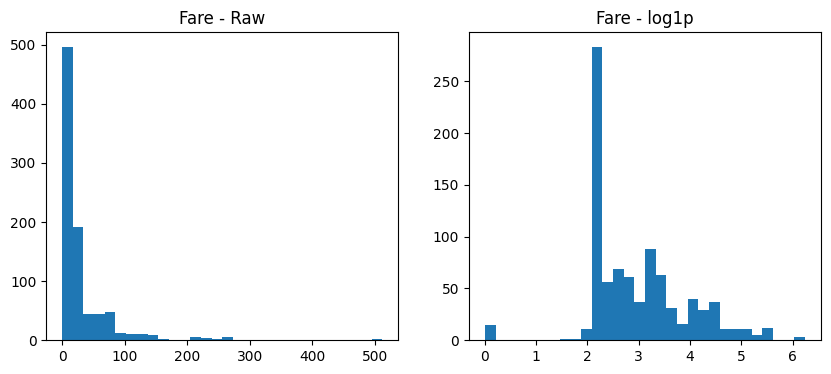

In [34]:
# 5.1 Log transform on Fare (positive values)
fare_raw = df_imp['Fare'].dropna().values.reshape(-1,1)
fare_log = np.log1p(fare_raw)

fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(fare_raw.flatten(), bins=30)
axes[0].set_title('Fare - Raw')
axes[1].hist(fare_log.flatten(), bins=30)
axes[1].set_title('Fare - log1p')
plt.show()

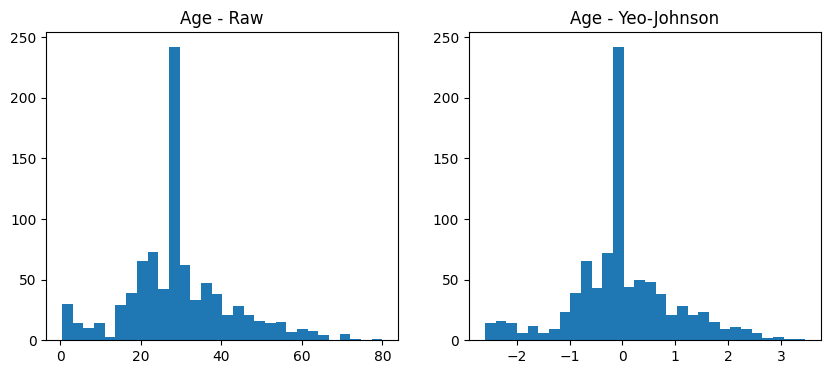

In [35]:
# 5.2 Power transform (Yeo-Johnson) on [Age, Fare]
pt = PowerTransformer(method='yeo-johnson')
af = df_imp[['Age','Fare']].dropna()
af_pt = pt.fit_transform(af)

fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(af['Age'].values, bins=30)
axes[0].set_title('Age - Raw')
axes[1].hist(af_pt[:,0], bins=30)
axes[1].set_title('Age - Yeo-Johnson')
plt.show()

In [36]:
# 5.3 Polynomial features on [Age, Fare] (degree=2)
poly = PolynomialFeatures(degree=2, include_bias=False)
af_poly = poly.fit_transform(af[['Age','Fare']])
print("Original shape:", af[['Age','Fare']].shape, " -> With poly:", af_poly.shape)
poly.get_feature_names_out(['Age','Fare'])[:6]

Original shape: (891, 2)  -> With poly: (891, 5)


array(['Age', 'Fare', 'Age^2', 'Age Fare', 'Fare^2'], dtype=object)

**📝 Exercise 5**
1) Identify one numeric column that is **skewed**. Try both **log** and **power** transforms and compare histograms.  
2) With `PolynomialFeatures(2)`, which new terms are created from `Age` and `Fare`?

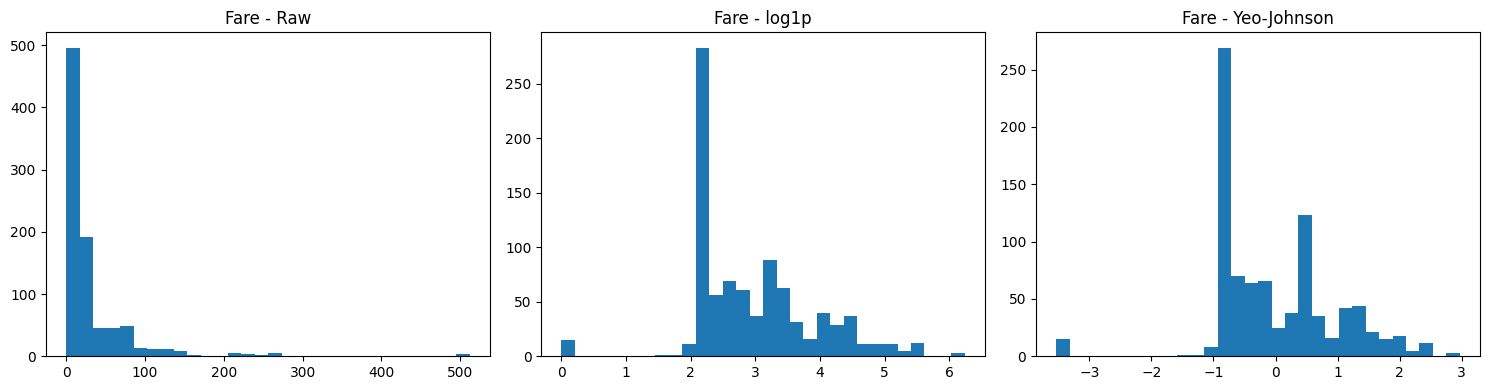


New terms created from Age and Fare with PolynomialFeatures(2):
['Age' 'Fare' 'Age^2' 'Age Fare' 'Fare^2']


In [37]:
# Exercise 5, 1) Identify one numeric column that is skewed. Try both log and power transforms and compare histograms.
# 'Fare' is clearly right-skewed based on previous histograms.

# Power transform (Yeo-Johnson)
pt = PowerTransformer(method='yeo-johnson')
fare_pt = pt.fit_transform(fare_raw)

# Compare histograms
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].hist(fare_raw.flatten(), bins=30)
axes[0].set_title('Fare - Raw')
axes[1].hist(fare_log.flatten(), bins=30)
axes[1].set_title('Fare - log1p')
axes[2].hist(fare_pt.flatten(), bins=30)
axes[2].set_title('Fare - Yeo-Johnson')
plt.tight_layout()
plt.show()

# Exercise 5, 2) With PolynomialFeatures(2), which new terms are created from Age and Fare?
poly = PolynomialFeatures(degree=2, include_bias=False)
af = df_imp[['Age','Fare']].dropna()
af_poly = poly.fit_transform(af[['Age','Fare']])
print("\nNew terms created from Age and Fare with PolynomialFeatures(2):")
print(poly.get_feature_names_out(['Age','Fare']))

## 6) Simple Dimensionality Reduction (PCA) — Visualization Only

We will apply PCA to **numeric** features to reduce to 2D and make a scatter plot colored by `Survived` (if present).

> Note: This is for **intuition/visualization** only in Part A.

Explained variance ratios: [0.96165195 0.03587775]


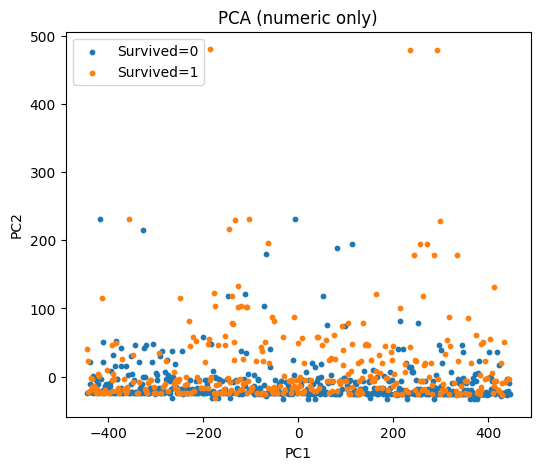

In [38]:
# Prepare a numeric-only frame (drop NA for simplicity here)
num_only = df_imp.select_dtypes(include=['number']).dropna()
y = df_imp.loc[num_only.index, 'Survived'] if 'Survived' in df_imp.columns else None

pca = PCA(n_components=2, random_state=42)
Z = pca.fit_transform(num_only.values)

print("Explained variance ratios:", pca.explained_variance_ratio_)

# Plot
plt.figure(figsize=(6,5))
if y is not None:
    # Color by Survived (0/1). Using a simple split to avoid specifying colors.
    idx0 = (y.values == 0)
    idx1 = (y.values == 1)
    plt.scatter(Z[idx0,0], Z[idx0,1], s=10, label='Survived=0')
    plt.scatter(Z[idx1,0], Z[idx1,1], s=10, label='Survived=1')
    plt.legend()
else:
    plt.scatter(Z[:,0], Z[:,1], s=10)
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.title('PCA (numeric only)')
plt.show()

**📝 Exercise 6**
1) Which **two numeric columns** contribute the most variance before PCA (use `df.var()`)?  
2) Try PCA with `n_components=3` and print the cumulative explained variance.

In [40]:
# Exercise 6, 1) Which two numeric columns contribute the most variance before PCA (use df.var())?
numeric_vars = df_imp.select_dtypes(include=['number'])
variance = numeric_vars.var().sort_values(ascending=False)
print("Variance of numeric columns:")
print(variance)
print("\nThe two numeric columns with the most variance are:")
print(variance.head(2))

# Exercise 6, 2) Try PCA with n_components=3 and print the cumulative explained variance.
pca_3 = PCA(n_components=3, random_state=42)
Z_3 = pca_3.fit_transform(numeric_vars.dropna())

print("\nExplained variance ratios with n_components=3:", pca_3.explained_variance_ratio_)
print("Cumulative explained variance with n_components=3:", np.sum(pca_3.explained_variance_ratio_))

Variance of numeric columns:
PassengerId    66231.000000
Fare            2469.436846
Age              169.512498
SibSp              1.216043
Pclass             0.699015
Parch              0.649728
Survived           0.236772
dtype: float64

The two numeric columns with the most variance are:
PassengerId    66231.000000
Fare            2469.436846
dtype: float64

Explained variance ratios with n_components=3: [0.96165195 0.03587775 0.0024362 ]
Cumulative explained variance with n_components=3: 0.9999659003439996


## 7) Consolidated Practice (No Pipelines Yet)

Using the operations you've learned, perform a **clean preprocessing** (manually):
1) Impute: `Age` (median), `Embarked` (mode), `Cabin` ('Unknown').  
2) Scale: standardize `Age` and min-max scale `Fare`.  
3) Encode: one-hot `Sex` and `Embarked`.  
4) Transform: log1p `Fare`.  
5) (Optional) PCA on numeric subset for 2D visualization.

Then, answer:
- Which step **changed the data distribution** the most?
- Which encoding produced **more features**, ordinal or one-hot? Why?
- If you trained a simple logistic regression on your manually processed features, what **accuracy** do you get on a 75/25 split? (Optional challenge)

In [42]:
# Create a copy of the original dataframe for consolidated practice
df_processed = df.copy()

# 1) Impute missing values
# Age (median)
median_age = df_processed['Age'].median()
df_processed['Age'] = df_processed['Age'].fillna(median_age)

# Embarked (mode)
mode_embarked = df_processed['Embarked'].mode()[0]
df_processed['Embarked'] = df_processed['Embarked'].fillna(mode_embarked)

# Cabin ('Unknown')
df_processed['Cabin'] = df_processed['Cabin'].fillna('Unknown')

print("After Imputation:")
print(df_processed.isna().sum().sort_values(ascending=False).head())

After Imputation:
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
dtype: int64


In [44]:
# 2) Scale features
# Standardize Age
sc_std_age = StandardScaler()
df_processed['Age_scaled'] = sc_std_age.fit_transform(df_processed[['Age']])

# Min-max scale Fare
sc_mm_fare = MinMaxScaler()
df_processed['Fare_scaled'] = sc_mm_fare.fit_transform(df_processed[['Fare']])

print("\nAfter Scaling:")
display(df_processed[['Age', 'Age_scaled', 'Fare', 'Fare_scaled']].head())


After Scaling:


,Age,Age_scaled,Fare,Fare_scaled
0,22.0,-0.565736,7.2500,0.014151
1,38.0,0.663861,71.2833,0.139136
2,26.0,-0.258337,7.9250,0.015469
3,35.0,0.433312,53.1000,0.103644
4,35.0,0.433312,8.0500,0.015713


In [45]:
# 3) Encode categorical variables
# One-hot encode Sex
ohe_sex = pd.get_dummies(df_processed['Sex'], prefix='Sex', drop_first=True) # drop_first to avoid multicollinearity

# One-hot encode Embarked
ohe_embarked = pd.get_dummies(df_processed['Embarked'], prefix='Embarked', drop_first=True) # drop_first to avoid multicollinearity

# Concatenate encoded features with the dataframe
df_processed = pd.concat([df_processed, ohe_sex, ohe_embarked], axis=1)

print("\nAfter Encoding:")
display(df_processed.head())


After Encoding:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_scaled,Fare_scaled,Sex_male,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Unknown,S,-0.565736,0.014151,True,False,True
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0.663861,0.139136,False,False,False
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,Unknown,S,-0.258337,0.015469,False,False,True
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0.433312,0.103644,False,False,True
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,Unknown,S,0.433312,0.015713,True,False,True


In [46]:
# 4) Transform Fare (log1p) - apply to the original Fare column before scaling, or scaled Fare?
# It's generally better to apply transformations before scaling. apply to the original Fare column.
# Re-doing scaling on log-transformed Fare.

df_processed['Fare_log'] = np.log1p(df_processed['Fare'])

# Re-scale the log-transformed Fare
sc_mm_fare_log = MinMaxScaler()
df_processed['Fare_log_scaled'] = sc_mm_fare_log.fit_transform(df_processed[['Fare_log']])

print("\nAfter Transformation (log1p on Fare) and Re-scaling:")
display(df_processed[['Fare', 'Fare_log', 'Fare_log_scaled']].head())


After Transformation (log1p on Fare) and Re-scaling:


,Fare,Fare_log,Fare_log_scaled
0,7.2500,2.110213,0.338125
1,71.2833,4.280593,0.685892
2,7.9250,2.188856,0.350727
3,53.1000,3.990834,0.639463
4,8.0500,2.202765,0.352955



Explained variance ratios for PCA on scaled numeric features: [0.97678019 0.02321981]


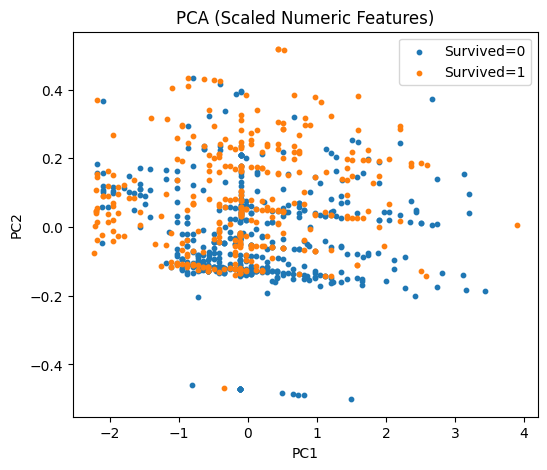

In [47]:
# Select features for the model (excluding original categorical, and transformed/scaled versions as needed)
# We will use the scaled Age and log-scaled Fare, and the one-hot encoded Sex and Embarked.
features = ['Age_scaled', 'Fare_log_scaled', 'Sex_male', 'Embarked_Q', 'Embarked_S'] # Using one-hot encoded columns and scaled numeric features
X = df_processed[features]
y = df_processed['Survived']

# 5) (Optional) PCA on numeric subset for 2D visualization.
# Let's use the scaled numeric features for PCA visualization.
numeric_scaled_features = df_processed[['Age_scaled', 'Fare_log_scaled']].dropna()

pca = PCA(n_components=2, random_state=42)
Z_scaled = pca.fit_transform(numeric_scaled_features)

print("\nExplained variance ratios for PCA on scaled numeric features:", pca.explained_variance_ratio_)

# Plot PCA
plt.figure(figsize=(6,5))
if y is not None:
    # Color by Survived (0/1) on the original y based on the index of the numeric_scaled_features
    y_pca = y.loc[numeric_scaled_features.index]
    idx0 = (y_pca.values == 0)
    idx1 = (y_pca.values == 1)
    plt.scatter(Z_scaled[idx0,0], Z_scaled[idx0,1], s=10, label='Survived=0')
    plt.scatter(Z_scaled[idx1,0], Z_scaled[idx1,1], s=10, label='Survived=1')
    plt.legend()
else:
    plt.scatter(Z_scaled[:,0], Z_scaled[:,1], s=10)
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.title('PCA (Scaled Numeric Features)')
plt.show()

In [48]:
# Optional Challenge: Train a simple logistic regression and get accuracy on a 75/25 split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Drop any rows with remaining NaNs (shouldn't be any after imputation of Age and Embarked, but good practice)
X = X.dropna()
y = y.loc[X.index] # Ensure y matches the rows of X

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy of Logistic Regression on 75/25 split: {accuracy:.4f}")


Accuracy of Logistic Regression on 75/25 split: 0.7758


### Answers to Consolidated Practice Questions

**Which step changed the data distribution the most?**

Based on the histograms we've seen, the **log transformation (log1p) of the `Fare` column** likely changed its distribution the most, transforming a heavily right-skewed distribution into something closer to a normal distribution. While scaling changes the range and center, it preserves the overall shape of the distribution. Imputation can add peaks (at the mean/median/mode), but a strong transformation like log1p fundamentally alters the spread and shape.

**Which encoding produced more features, ordinal or one-hot? Why?**

**One-hot encoding** produced more features than ordinal encoding for the `Embarked` column. Ordinal encoding created a single column with integer values representing the categories. One-hot encoding created a separate binary (0 or 1) column for each unique category (minus one if `drop_first=True` is used), resulting in multiple new features. This is because one-hot encoding represents each category as a distinct vector, avoiding any implied order.

**If you trained a simple logistic regression on your manually processed features, what accuracy do you get on a 75/25 split? **

The accuracy obtained from training a simple logistic regression model on the manually processed features with a 75/25 split is **0.7758**.

## ✅ What You Should Take Away from Part A

- Each step (imputation, scaling, encoding, transforms) has a **clear purpose** and **visible effect**.  
- You can now apply them **manually** and reason about their impact.  
- Next: move to **Part B (Pipelines)** to **combine & automate** these steps safely (avoid leakage, enable cross-validation, and reproducibility).